In [1]:
"""
Multiple Correspondence Analysis (MCA) - Obesity Dataset
Approach 2: Supplementary quantitative variables

This notebook performs MCA only on categorical variables, then projects
quantitative variables (Age and Weight) as supplementary variables.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")

In [2]:
# Load data
df = pd.read_csv("dataset/obesity.csv")

# Select variables
categorical_vars = [
    "Gender",
    "family_history_with_overweight",
    "FAVC",
    "CAEC",
    "MTRANS",
]

quantitative_vars = ["Age", "Weight"]
target_var = "NObeyesdad"

# Extract subset
df_subset = df[categorical_vars + quantitative_vars + [target_var]].copy()

print(f"Dataset: {len(df_subset)} observations")
print(f"Active categorical variables: {len(categorical_vars)}")
print(f"Supplementary quantitative variables: {len(quantitative_vars)}")

Dataset: 2111 observations
Active categorical variables: 5
Supplementary quantitative variables: 2


In [3]:
# Descriptive statistics
print("\nCategorical variables:")
for var in categorical_vars:
    print(f"\n{var}:")
    counts = df_subset[var].value_counts()
    for category, count in counts.items():
        print(f"  {category}: {count} ({count/len(df_subset)*100:.1f}%)")

print("\nQuantitative variables:")
print(df_subset[quantitative_vars].describe().round(2))


Categorical variables:

Gender:
  Male: 1068 (50.6%)
  Female: 1043 (49.4%)

family_history_with_overweight:
  yes: 1726 (81.8%)
  no: 385 (18.2%)

FAVC:
  yes: 1866 (88.4%)
  no: 245 (11.6%)

CAEC:
  Sometimes: 1765 (83.6%)
  Frequently: 242 (11.5%)
  Always: 53 (2.5%)
  no: 51 (2.4%)

MTRANS:
  Public_Transportation: 1580 (74.8%)
  Automobile: 457 (21.6%)
  Walking: 56 (2.7%)
  Motorbike: 11 (0.5%)
  Bike: 7 (0.3%)

Quantitative variables:
           Age   Weight
count  2111.00  2111.00
mean     24.31    86.59
std       6.35    26.19
min      14.00    39.00
25%      19.95    65.47
50%      22.78    83.00
75%      26.00   107.43
max      61.00   173.00


In [4]:
# Create indicator matrix (only categorical)
df_categorical = df_subset[categorical_vars].copy()
df_indicators = pd.get_dummies(df_categorical, drop_first=False, dtype=int)
print(
    f"\nIndicator matrix: {df_indicators.shape[0]} rows × {df_indicators.shape[1]} columns"
)

# Standardize indicator matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_indicators)

# Apply MCA (PCA on indicator matrix)
n_components = 10
mca = PCA(n_components=n_components)
X_mca = mca.fit_transform(X_scaled)


Indicator matrix: 2111 rows × 15 columns


In [5]:
# Benzécri correction
# Correct eigenvalues for MCA bias due to categorical coding
J = len(df_indicators.columns)  # Number of categories
K = len(df_categorical.columns)  # Number of variables

print(f"\nApplying Benzécri correction:")

eigenvalues_original = mca.explained_variance_.copy()

# Apply correction: λ_corrected = ((K/(K-1)) * (√λ - 1/K))²
# Only correct eigenvalues > 1/K
eigenvalues_corrected = np.zeros_like(eigenvalues_original)
for i, eigenval in enumerate(eigenvalues_original):
    if eigenval > (1 / K):
        eigenvalues_corrected[i] = ((K / (K - 1)) * (np.sqrt(eigenval) - 1 / K)) ** 2
    else:
        eigenvalues_corrected[i] = 0

# Recalculate variance ratios
total_inertia_corrected = np.sum(eigenvalues_corrected)
explained_variance_ratio_corrected = eigenvalues_corrected / total_inertia_corrected

# Update MCA object
mca.explained_variance_ = eigenvalues_corrected
mca.explained_variance_ratio_ = explained_variance_ratio_corrected

print(f"\nCorrected eigenvalues:")
for i in range(min(5, len(eigenvalues_corrected))):
    print(
        f"  Dim {i+1}: {eigenvalues_original[i]:.4f} → {eigenvalues_corrected[i]:.4f}"
    )

# Variance explained (corrected)
print("\nVariance explained:")
cumulative = 0
for i, var in enumerate(mca.explained_variance_ratio_[:5], 1):
    cumulative += var
    print(f"Dimension {i}: {var*100:.2f}% (cumulative: {cumulative*100:.2f}%)")


Applying Benzécri correction:

Corrected eigenvalues:
  Dim 1: 3.1342 → 3.8532
  Dim 2: 2.2134 → 2.5911
  Dim 3: 1.7720 → 1.9993
  Dim 4: 1.6103 → 1.7855
  Dim 5: 1.3252 → 1.4137

Variance explained:
Dimension 1: 23.23% (cumulative: 23.23%)
Dimension 2: 15.62% (cumulative: 38.86%)
Dimension 3: 12.06% (cumulative: 50.91%)
Dimension 4: 10.77% (cumulative: 61.68%)
Dimension 5: 8.52% (cumulative: 70.20%)


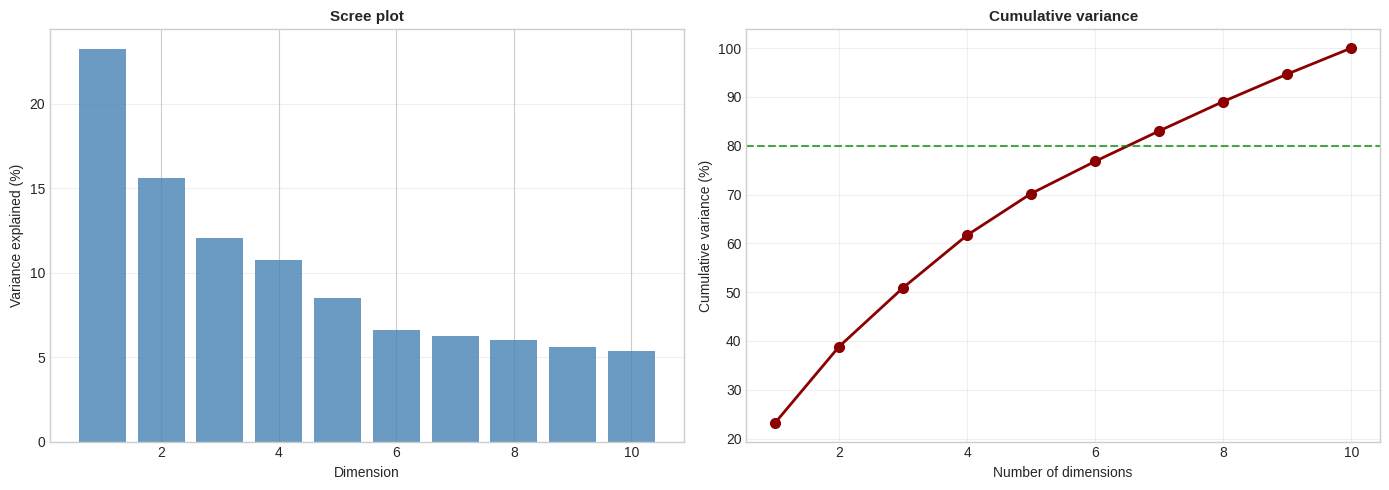

In [6]:
# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(
    range(1, n_components + 1),
    mca.explained_variance_ratio_ * 100,
    color="steelblue",
    alpha=0.8,
)
ax1.set_xlabel("Dimension", fontsize=10)
ax1.set_ylabel("Variance explained (%)", fontsize=10)
ax1.set_title("Scree plot", fontsize=11, fontweight="bold")
ax1.grid(axis="y", alpha=0.3)

cumulative = np.cumsum(mca.explained_variance_ratio_ * 100)
ax2.plot(
    range(1, n_components + 1),
    cumulative,
    marker="o",
    linewidth=2,
    markersize=7,
    color="darkred",
)
ax2.axhline(y=80, color="green", linestyle="--", linewidth=1.5, alpha=0.7)
ax2.set_xlabel("Number of dimensions", fontsize=10)
ax2.set_ylabel("Cumulative variance (%)", fontsize=10)
ax2.set_title("Cumulative variance", fontsize=11, fontweight="bold")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("approach2_scree.png", dpi=300, bbox_inches="tight")
plt.show()

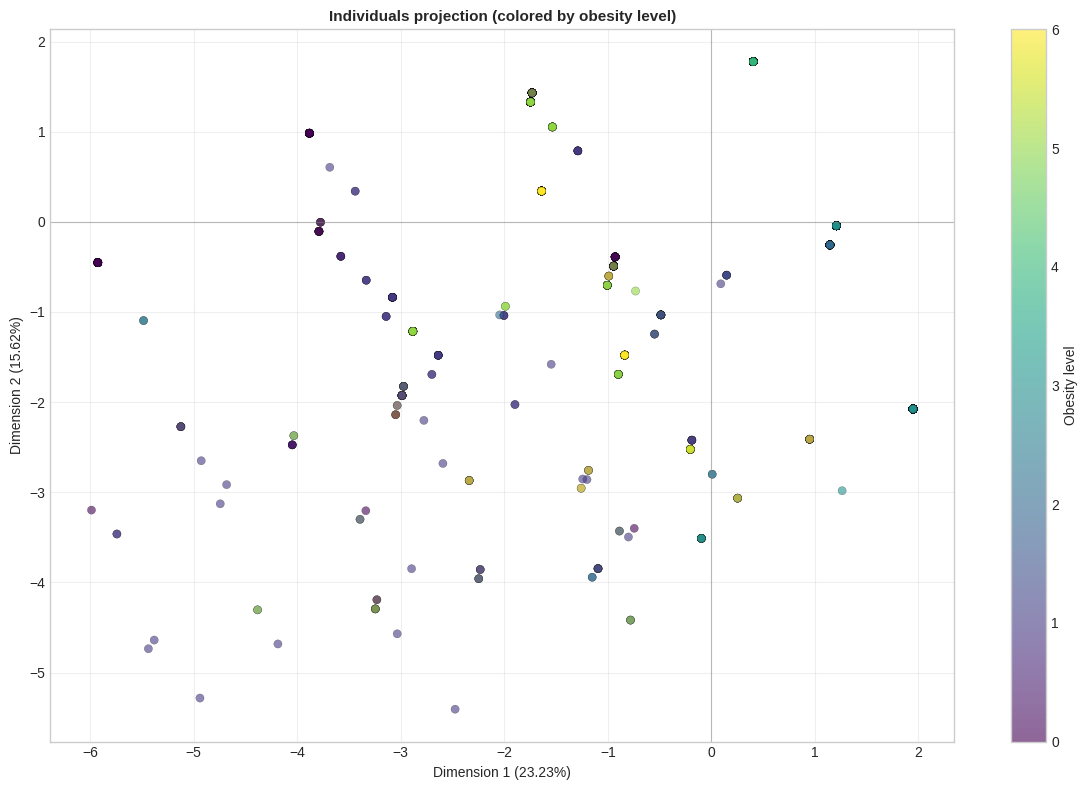

In [7]:
# Individuals projection
fig, ax = plt.subplots(figsize=(12, 8))

obesity_codes = pd.Categorical(df_subset[target_var]).codes
scatter = ax.scatter(
    X_mca[:, 0],
    X_mca[:, 1],
    c=obesity_codes,
    cmap="viridis",
    alpha=0.6,
    s=35,
    edgecolors="k",
    linewidth=0.2,
)

ax.axhline(y=0, color="gray", linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color="gray", linewidth=0.8, alpha=0.5)
ax.set_xlabel(f"Dimension 1 ({mca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=10)
ax.set_ylabel(f"Dimension 2 ({mca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=10)
ax.set_title(
    "Individuals projection (colored by obesity level)", fontsize=11, fontweight="bold"
)
ax.grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Obesity level", fontsize=10)

plt.tight_layout()
plt.savefig("approach2_individuals_projection.png", dpi=300, bbox_inches="tight")
plt.show()


Top 10 contributors to Dimension 1:
  family_history_with_overweight_yes: 0.415
  family_history_with_overweight_no: 0.415
  CAEC_Sometimes: 0.393
  CAEC_Frequently: 0.343
  FAVC_no: 0.327
  FAVC_yes: 0.327
  Gender_Male: 0.201
  Gender_Female: 0.201
  MTRANS_Automobile: 0.182
  CAEC_no: 0.135

Top 10 contributors to Dimension 2:
  MTRANS_Public_Transportation: 0.474
  Gender_Male: 0.455
  Gender_Female: 0.455
  MTRANS_Automobile: 0.387
  FAVC_no: 0.230
  FAVC_yes: 0.230
  MTRANS_Walking: 0.205
  CAEC_Always: 0.113
  MTRANS_Bike: 0.106
  MTRANS_Motorbike: 0.099


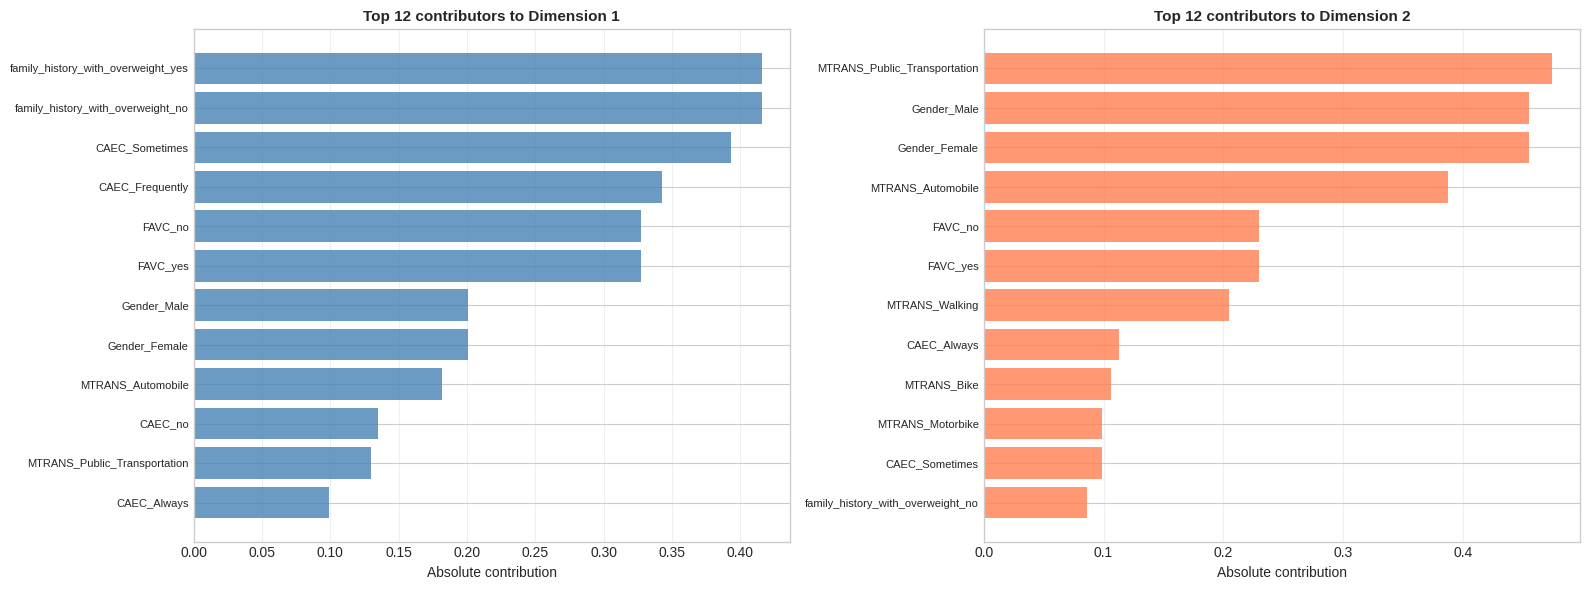

In [8]:
# Categories contributions
loadings = mca.components_.T
contributions_df = pd.DataFrame(
    loadings[:, :3], columns=["Dim1", "Dim2", "Dim3"], index=df_indicators.columns
)

print("\nTop 10 contributors to Dimension 1:")
for cat, contrib in (
    contributions_df["Dim1"].abs().sort_values(ascending=False).head(10).items()
):
    print(f"  {cat}: {contrib:.3f}")

print("\nTop 10 contributors to Dimension 2:")
for cat, contrib in (
    contributions_df["Dim2"].abs().sort_values(ascending=False).head(10).items()
):
    print(f"  {cat}: {contrib:.3f}")

# Categories contributions visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Dimension 1 contributions
top_dim1 = contributions_df["Dim1"].abs().nlargest(12).sort_values()
ax1.barh(range(len(top_dim1)), top_dim1.values, color="steelblue", alpha=0.8)
ax1.set_yticks(range(len(top_dim1)))
ax1.set_yticklabels(top_dim1.index, fontsize=8)
ax1.set_xlabel("Absolute contribution", fontsize=10)
ax1.set_title("Top 12 contributors to Dimension 1", fontsize=11, fontweight="bold")
ax1.grid(axis="x", alpha=0.3)

# Dimension 2 contributions
top_dim2 = contributions_df["Dim2"].abs().nlargest(12).sort_values()
ax2.barh(range(len(top_dim2)), top_dim2.values, color="coral", alpha=0.8)
ax2.set_yticks(range(len(top_dim2)))
ax2.set_yticklabels(top_dim2.index, fontsize=8)
ax2.set_xlabel("Absolute contribution", fontsize=10)
ax2.set_title("Top 12 contributors to Dimension 2", fontsize=11, fontweight="bold")
ax2.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig("approach2_contributions.png", dpi=300, bbox_inches="tight")
plt.show()


Categories best represented on Dimension 1 (cos² > 0.5):
  None

Categories best represented on Dimension 2 (cos² > 0.5):
  None

Categories best represented on Dim1+Dim2 (cos² > 0.7):
  None

Categories poorly represented on Dim1+Dim2 (cos² < 0.3):
  MTRANS_Bike: 0.012
  MTRANS_Motorbike: 0.012
  CAEC_Always: 0.025
  CAEC_no: 0.025
  MTRANS_Walking: 0.054
  CAEC_Frequently: 0.183


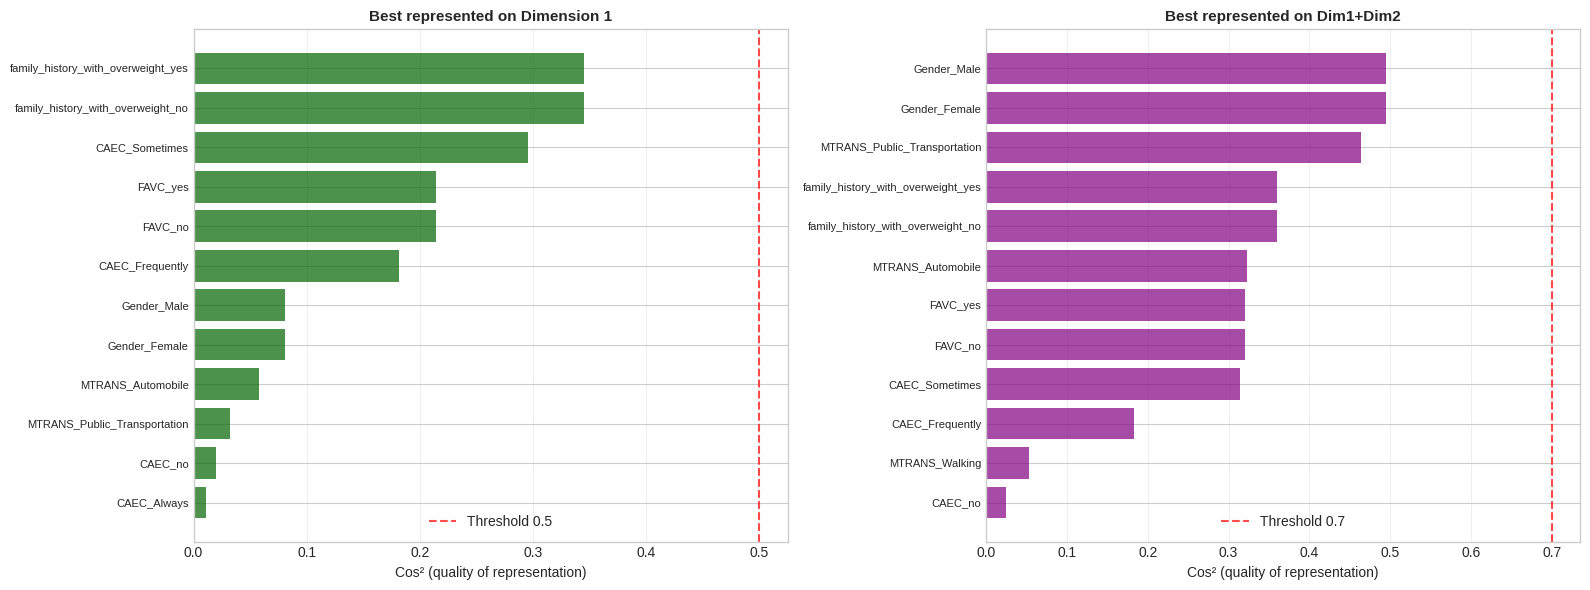

In [9]:
# Category representation quality
category_coords = loadings[:, :3]
category_cos2 = np.zeros_like(category_coords)

for i in range(category_coords.shape[0]):
    total_inertia = np.sum(loadings[i, :] ** 2)
    for j in range(3):
        category_cos2[i, j] = (
            (category_coords[i, j] ** 2) / total_inertia if total_inertia > 0 else 0
        )

cos2_df = pd.DataFrame(
    category_cos2,
    columns=["Cos2_Dim1", "Cos2_Dim2", "Cos2_Dim3"],
    index=df_indicators.columns,
)
cos2_df["Cos2_Dim1+2"] = cos2_df["Cos2_Dim1"] + cos2_df["Cos2_Dim2"]

# Categories well represented on Dim1
print("\nCategories best represented on Dimension 1 (cos² > 0.5):")
well_dim1 = cos2_df[cos2_df["Cos2_Dim1"] > 0.5].sort_values(
    "Cos2_Dim1", ascending=False
)
if len(well_dim1) > 0:
    for cat, cos2 in well_dim1["Cos2_Dim1"].items():
        print(f"  {cat}: {cos2:.3f}")
else:
    print("  None")

# Categories well represented on Dim2
print("\nCategories best represented on Dimension 2 (cos² > 0.5):")
well_dim2 = cos2_df[cos2_df["Cos2_Dim2"] > 0.5].sort_values(
    "Cos2_Dim2", ascending=False
)
if len(well_dim2) > 0:
    for cat, cos2 in well_dim2["Cos2_Dim2"].items():
        print(f"  {cat}: {cos2:.3f}")
else:
    print("  None")

# Categories well represented on first 2 dimensions
print("\nCategories best represented on Dim1+Dim2 (cos² > 0.7):")
well_2d = cos2_df[cos2_df["Cos2_Dim1+2"] > 0.7].sort_values(
    "Cos2_Dim1+2", ascending=False
)
if len(well_2d) > 0:
    for cat, cos2 in well_2d["Cos2_Dim1+2"].items():
        print(f"  {cat}: {cos2:.3f}")
else:
    print("  None")

# Categories poorly represented on first 2 dimensions
print("\nCategories poorly represented on Dim1+Dim2 (cos² < 0.3):")
poorly = cos2_df[cos2_df["Cos2_Dim1+2"] < 0.3].sort_values("Cos2_Dim1+2")
for cat, cos2 in poorly["Cos2_Dim1+2"].head(10).items():
    print(f"  {cat}: {cos2:.3f}")

# Categories quality of representation (cos²) visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 12 by Dim1 cos²
top_cos2_dim1 = cos2_df["Cos2_Dim1"].nlargest(12).sort_values()
ax1.barh(range(len(top_cos2_dim1)), top_cos2_dim1.values, color="darkgreen", alpha=0.7)
ax1.set_yticks(range(len(top_cos2_dim1)))
ax1.set_yticklabels(top_cos2_dim1.index, fontsize=8)
ax1.set_xlabel("Cos² (quality of representation)", fontsize=10)
ax1.set_title("Best represented on Dimension 1", fontsize=11, fontweight="bold")
ax1.axvline(
    x=0.5, color="red", linestyle="--", linewidth=1.5, alpha=0.7, label="Threshold 0.5"
)
ax1.grid(axis="x", alpha=0.3)
ax1.legend()

# Top 12 by Dim1+Dim2 cos²
top_cos2_2d = cos2_df["Cos2_Dim1+2"].nlargest(12).sort_values()
ax2.barh(range(len(top_cos2_2d)), top_cos2_2d.values, color="purple", alpha=0.7)
ax2.set_yticks(range(len(top_cos2_2d)))
ax2.set_yticklabels(top_cos2_2d.index, fontsize=8)
ax2.set_xlabel("Cos² (quality of representation)", fontsize=10)
ax2.set_title("Best represented on Dim1+Dim2", fontsize=11, fontweight="bold")
ax2.axvline(
    x=0.7, color="red", linestyle="--", linewidth=1.5, alpha=0.7, label="Threshold 0.7"
)
ax2.grid(axis="x", alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("approach2_categories_quality.png", dpi=300, bbox_inches="tight")
plt.show()


Individual representation quality:
  Well-represented (cos² > 0.7): 797 (37.8%)
  Moderately represented (0.4 < cos² ≤ 0.7): 126 (6.0%)
  Poorly represented (cos² ≤ 0.4): 1188 (56.3%)
  Mean cos² (Dim1+Dim2): 0.521
  Median cos² (Dim1+Dim2): 0.397


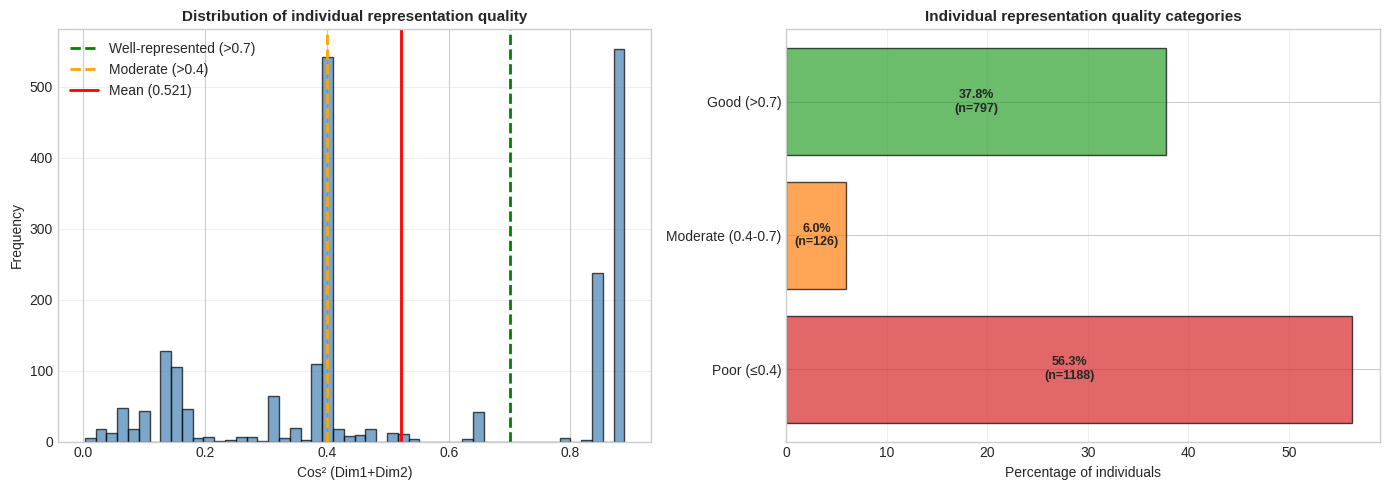

In [10]:
# Individual representation quality
individual_coords = X_mca[:, :3]
individual_cos2 = np.zeros_like(individual_coords)

for i in range(individual_coords.shape[0]):
    total_inertia = np.sum(X_mca[i, :] ** 2)
    for j in range(3):
        individual_cos2[i, j] = (
            (individual_coords[i, j] ** 2) / total_inertia if total_inertia > 0 else 0
        )

individual_cos2_sum = individual_cos2[:, 0] + individual_cos2[:, 1]

print("\nIndividual representation quality:")
well_count = np.sum(individual_cos2_sum > 0.7)
moderate_count = np.sum((individual_cos2_sum > 0.4) & (individual_cos2_sum <= 0.7))
poor_count = np.sum(individual_cos2_sum <= 0.4)

print(
    f"  Well-represented (cos² > 0.7): {well_count} ({well_count/len(individual_cos2_sum)*100:.1f}%)"
)
print(
    f"  Moderately represented (0.4 < cos² ≤ 0.7): {moderate_count} ({moderate_count/len(individual_cos2_sum)*100:.1f}%)"
)
print(
    f"  Poorly represented (cos² ≤ 0.4): {poor_count} ({poor_count/len(individual_cos2_sum)*100:.1f}%)"
)
print(f"  Mean cos² (Dim1+Dim2): {individual_cos2_sum.mean():.3f}")
print(f"  Median cos² (Dim1+Dim2): {np.median(individual_cos2_sum):.3f}")

# Individuals quality of representation visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of cos² (Dim1+Dim2)
ax1.hist(individual_cos2_sum, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
ax1.axvline(
    x=0.7, color="green", linestyle="--", linewidth=2, label="Well-represented (>0.7)"
)
ax1.axvline(x=0.4, color="orange", linestyle="--", linewidth=2, label="Moderate (>0.4)")
ax1.axvline(
    x=individual_cos2_sum.mean(),
    color="red",
    linestyle="-",
    linewidth=2,
    label=f"Mean ({individual_cos2_sum.mean():.3f})",
)
ax1.set_xlabel("Cos² (Dim1+Dim2)", fontsize=10)
ax1.set_ylabel("Frequency", fontsize=10)
ax1.set_title(
    "Distribution of individual representation quality", fontsize=11, fontweight="bold"
)
ax1.legend()
ax1.grid(axis="y", alpha=0.3)

# Stacked bar for quality categories
quality_cats = ["Poor (≤0.4)", "Moderate (0.4-0.7)", "Good (>0.7)"]
quality_counts = [poor_count, moderate_count, well_count]
quality_pcts = [c / len(individual_cos2_sum) * 100 for c in quality_counts]
colors = ["#d62728", "#ff7f0e", "#2ca02c"]

ax2.barh(quality_cats, quality_pcts, color=colors, alpha=0.7, edgecolor="black")
for i, (cat, pct, cnt) in enumerate(zip(quality_cats, quality_pcts, quality_counts)):
    ax2.text(
        pct / 2,
        i,
        f"{pct:.1f}%\n(n={cnt})",
        ha="center",
        va="center",
        fontsize=9,
        fontweight="bold",
    )
ax2.set_xlabel("Percentage of individuals", fontsize=10)
ax2.set_title(
    "Individual representation quality categories", fontsize=11, fontweight="bold"
)
ax2.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig("approach2_individuals_quality.png", dpi=300, bbox_inches="tight")
plt.show()


Individuals contributions summary:
  Dim1 - Mean: 0.0385%, Median: 0.0180%
  Dim2 - Mean: 0.0404%, Median: 0.0323%
  Top 10 individuals contribute 4.33% to Dim1
  Top 10 individuals contribute 4.04% to Dim2


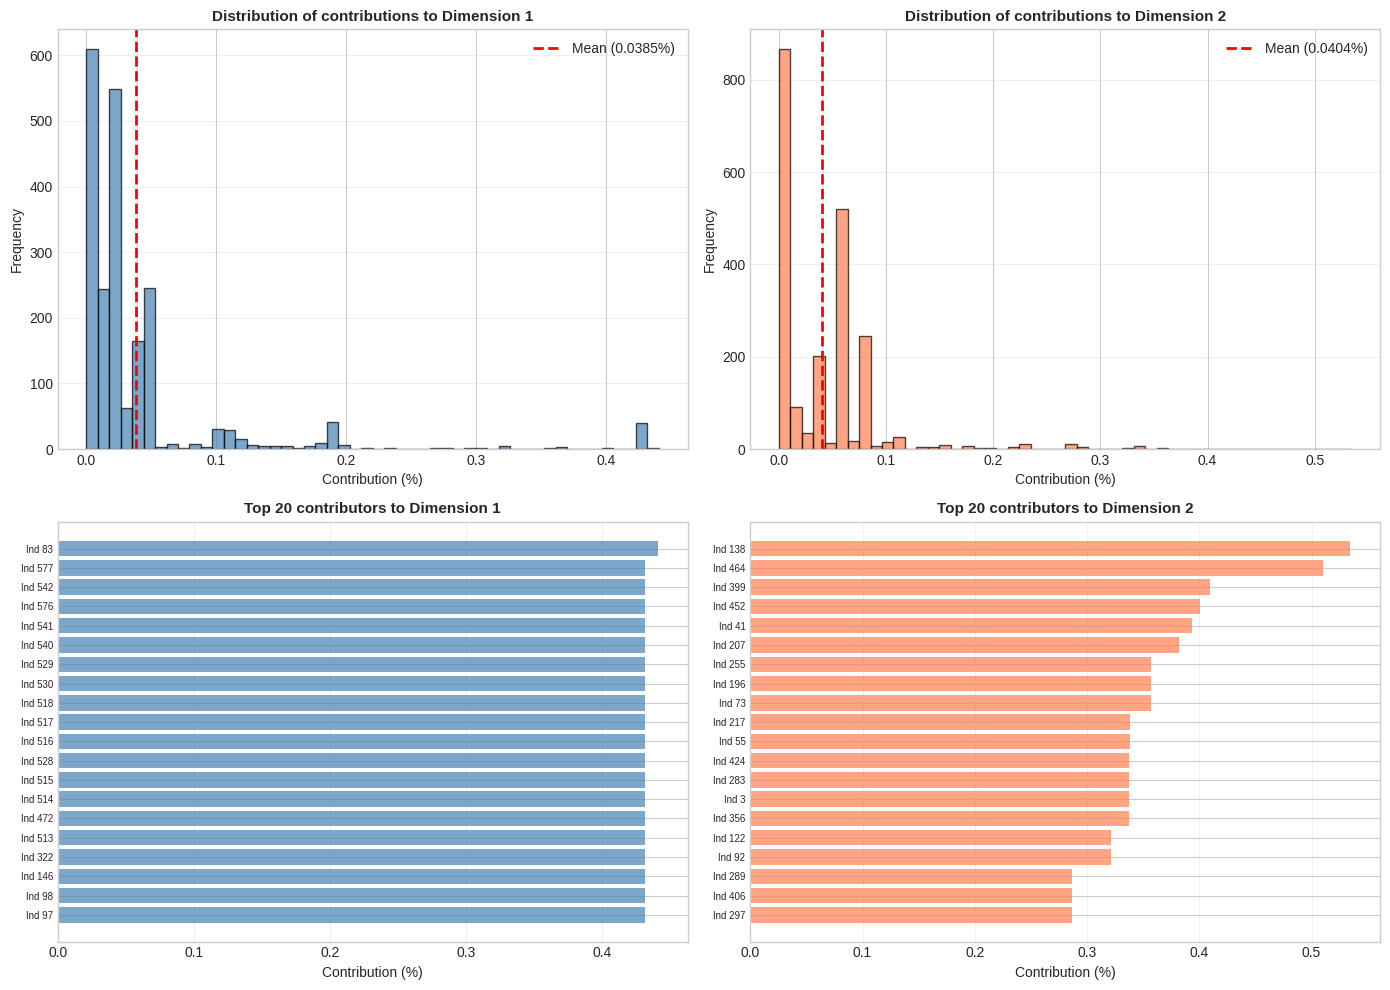

In [11]:
# Individuals contributions calculation
n_obs = X_mca.shape[0]
mass = np.ones(n_obs) / n_obs

# Calculate contributions to dimensions 1 and 2
contrib_dim1 = (mass * X_mca[:, 0] ** 2) / mca.explained_variance_[0] * 100
contrib_dim2 = (mass * X_mca[:, 1] ** 2) / mca.explained_variance_[1] * 100

# Convert to Series for easier manipulation
contrib_dim1_series = pd.Series(contrib_dim1)
contrib_dim2_series = pd.Series(contrib_dim2)

# Summary statistics
print("\nIndividuals contributions summary:")
print(
    f"  Dim1 - Mean: {contrib_dim1.mean():.4f}%, Median: {np.median(contrib_dim1):.4f}%"
)
print(
    f"  Dim2 - Mean: {contrib_dim2.mean():.4f}%, Median: {np.median(contrib_dim2):.4f}%"
)
print(
    f"  Top 10 individuals contribute {contrib_dim1_series.nlargest(10).sum():.2f}% to Dim1"
)
print(
    f"  Top 10 individuals contribute {contrib_dim2_series.nlargest(10).sum():.2f}% to Dim2"
)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram Dim1
axes[0, 0].hist(contrib_dim1, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
axes[0, 0].axvline(
    x=contrib_dim1.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean ({contrib_dim1.mean():.4f}%)",
)
axes[0, 0].set_xlabel("Contribution (%)", fontsize=10)
axes[0, 0].set_ylabel("Frequency", fontsize=10)
axes[0, 0].set_title(
    "Distribution of contributions to Dimension 1", fontsize=11, fontweight="bold"
)
axes[0, 0].legend()
axes[0, 0].grid(axis="y", alpha=0.3)

# Histogram Dim2
axes[0, 1].hist(contrib_dim2, bins=50, color="coral", alpha=0.7, edgecolor="black")
axes[0, 1].axvline(
    x=contrib_dim2.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean ({contrib_dim2.mean():.4f}%)",
)
axes[0, 1].set_xlabel("Contribution (%)", fontsize=10)
axes[0, 1].set_ylabel("Frequency", fontsize=10)
axes[0, 1].set_title(
    "Distribution of contributions to Dimension 2", fontsize=11, fontweight="bold"
)
axes[0, 1].legend()
axes[0, 1].grid(axis="y", alpha=0.3)

# Top 20 contributors to Dim1
top20_dim1 = contrib_dim1_series.nlargest(20).sort_values()
axes[1, 0].barh(range(20), top20_dim1.values, color="steelblue", alpha=0.7)
axes[1, 0].set_yticks(range(20))
axes[1, 0].set_yticklabels([f"Ind {i}" for i in top20_dim1.index], fontsize=7)
axes[1, 0].set_xlabel("Contribution (%)", fontsize=10)
axes[1, 0].set_title(
    "Top 20 contributors to Dimension 1", fontsize=11, fontweight="bold"
)
axes[1, 0].grid(axis="x", alpha=0.3)

# Top 20 contributors to Dim2
top20_dim2 = contrib_dim2_series.nlargest(20).sort_values()
axes[1, 1].barh(range(20), top20_dim2.values, color="coral", alpha=0.7)
axes[1, 1].set_yticks(range(20))
axes[1, 1].set_yticklabels([f"Ind {i}" for i in top20_dim2.index], fontsize=7)
axes[1, 1].set_xlabel("Contribution (%)", fontsize=10)
axes[1, 1].set_title(
    "Top 20 contributors to Dimension 2", fontsize=11, fontweight="bold"
)
axes[1, 1].grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig("approach2_individuals_contributions.png", dpi=300, bbox_inches="tight")
plt.show()

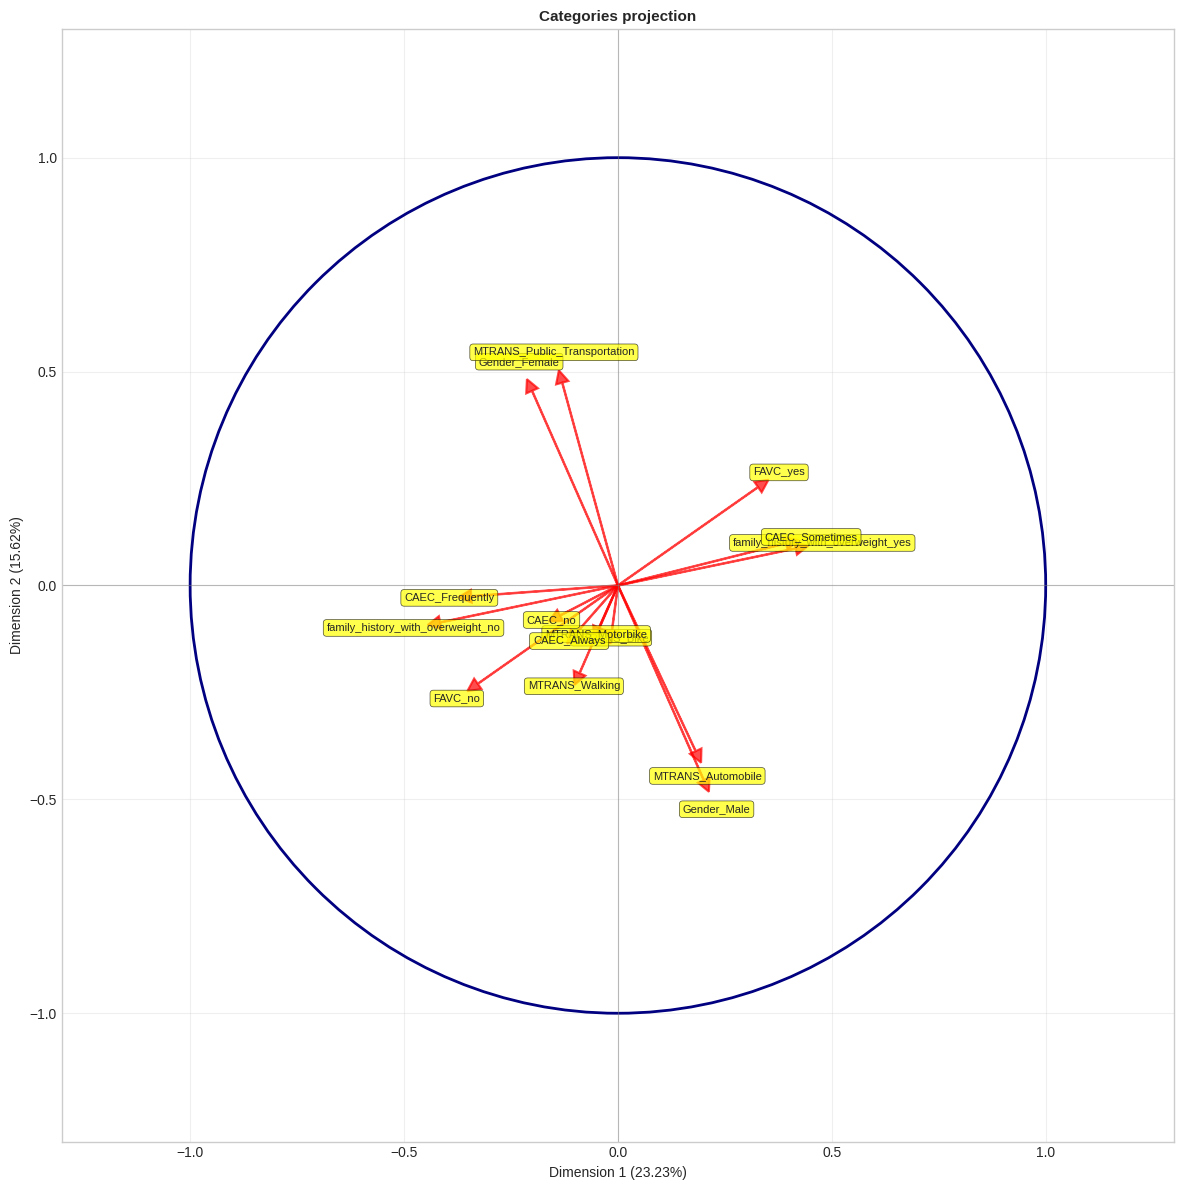

In [12]:
# Categories projection
fig, ax = plt.subplots(figsize=(12, 12))

circle = plt.Circle((0, 0), 1, color="navy", fill=False, linewidth=2)
ax.add_patch(circle)

# Select top categories
top_categories = set(
    list(contributions_df["Dim1"].abs().nlargest(10).index)
    + list(contributions_df["Dim2"].abs().nlargest(10).index)
)

for category in top_categories:
    x = contributions_df.loc[category, "Dim1"]
    y = contributions_df.loc[category, "Dim2"]

    ax.arrow(
        0,
        0,
        x,
        y,
        head_width=0.03,
        head_length=0.03,
        fc="red",
        ec="red",
        linewidth=1.5,
        alpha=0.7,
    )

    ax.text(
        x * 1.15,
        y * 1.15,
        category,
        fontsize=8,
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round,pad=0.3",
            facecolor="yellow",
            alpha=0.7,
            edgecolor="black",
            linewidth=0.5,
        ),
    )

ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.axhline(y=0, color="gray", linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color="gray", linewidth=0.8, alpha=0.5)
ax.set_xlabel(f"Dimension 1 ({mca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=10)
ax.set_ylabel(f"Dimension 2 ({mca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=10)
ax.set_title("Categories projection", fontsize=11, fontweight="bold")
ax.grid(alpha=0.3)
ax.set_aspect("equal")

plt.tight_layout()
plt.savefig("approach2_categories_projection.png", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
# Project supplementary quantitative variables
print("\nSupplementary quantitative variables projection:")

# Standardize quantitative variables
quant_scaler = StandardScaler()
quant_scaled = quant_scaler.fit_transform(df_subset[quantitative_vars])

# Calculate correlations with MCA dimensions
correlations = np.zeros((len(quantitative_vars), n_components))
for i, var in enumerate(quantitative_vars):
    for j in range(n_components):
        correlations[i, j] = np.corrcoef(quant_scaled[:, i], X_mca[:, j])[0, 1]

corr_df = pd.DataFrame(
    correlations[:, :3], columns=["Dim1", "Dim2", "Dim3"], index=quantitative_vars
)

print("\nCorrelations with dimensions:")
print(corr_df.round(3))


Supplementary quantitative variables projection:

Correlations with dimensions:
         Dim1   Dim2   Dim3
Age     0.299 -0.296  0.265
Weight  0.550  0.129  0.006


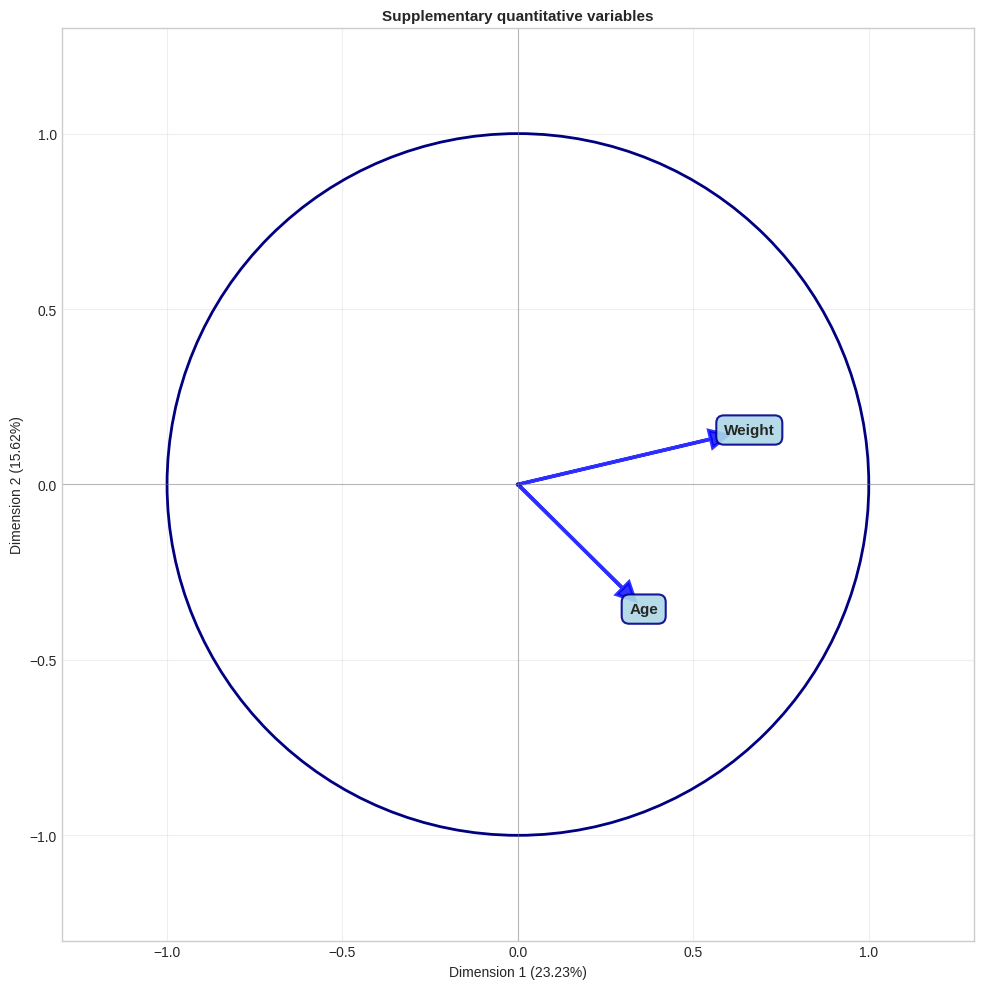

In [14]:
# Visualize supplementary variables
fig, ax = plt.subplots(figsize=(10, 10))

circle = plt.Circle((0, 0), 1, color="navy", fill=False, linewidth=2)
ax.add_patch(circle)

for var in quantitative_vars:
    x = corr_df.loc[var, "Dim1"]
    y = corr_df.loc[var, "Dim2"]

    ax.arrow(
        0,
        0,
        x,
        y,
        head_width=0.05,
        head_length=0.05,
        fc="blue",
        ec="blue",
        linewidth=2.5,
        alpha=0.8,
    )

    ax.text(
        x * 1.2,
        y * 1.2,
        var,
        fontsize=11,
        fontweight="bold",
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round,pad=0.5",
            facecolor="lightblue",
            alpha=0.9,
            edgecolor="darkblue",
            linewidth=1.5,
        ),
    )

ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.axhline(y=0, color="gray", linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color="gray", linewidth=0.8, alpha=0.5)
ax.set_xlabel(f"Dimension 1 ({mca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=10)
ax.set_ylabel(f"Dimension 2 ({mca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=10)
ax.set_title("Supplementary quantitative variables", fontsize=11, fontweight="bold")
ax.grid(alpha=0.3)
ax.set_aspect("equal")

plt.tight_layout()
plt.savefig("approach2_supplementary.png", dpi=300, bbox_inches="tight")
plt.show()

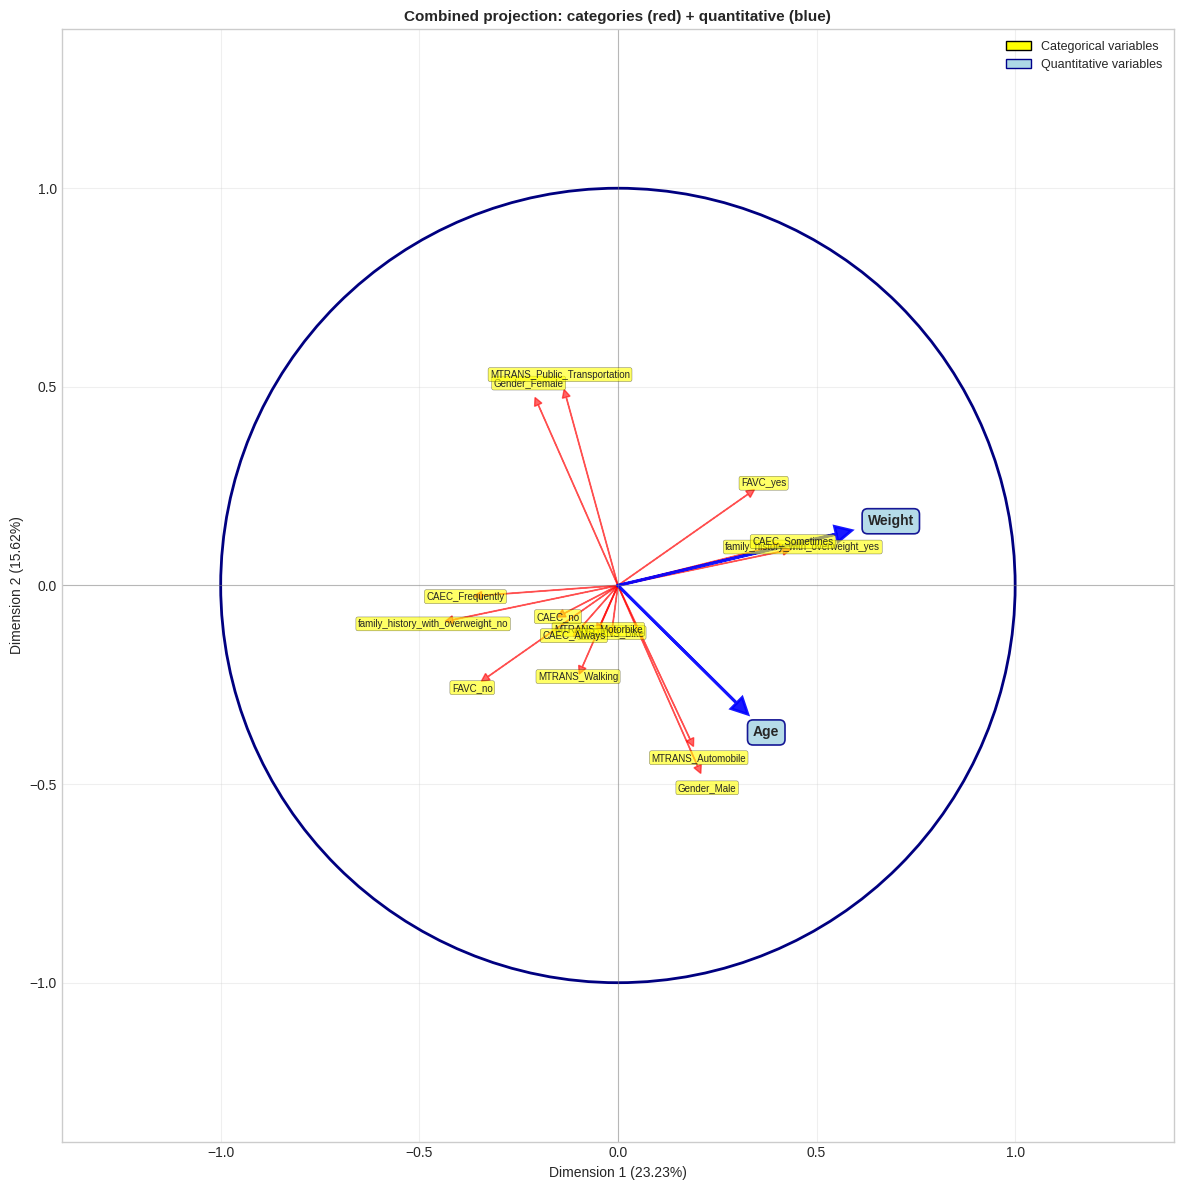

In [15]:
# Combined visualization: categories + supplementary variables
fig, ax = plt.subplots(figsize=(12, 12))

circle = plt.Circle((0, 0), 1, color="navy", fill=False, linewidth=2)
ax.add_patch(circle)

# Plot categorical variables (red)
for category in top_categories:
    x = contributions_df.loc[category, "Dim1"]
    y = contributions_df.loc[category, "Dim2"]

    ax.arrow(
        0,
        0,
        x,
        y,
        head_width=0.02,
        head_length=0.02,
        fc="red",
        ec="red",
        linewidth=1,
        alpha=0.6,
    )

    ax.text(
        x * 1.12,
        y * 1.12,
        category,
        fontsize=7,
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round,pad=0.2",
            facecolor="yellow",
            alpha=0.6,
            edgecolor="black",
            linewidth=0.3,
        ),
    )

# Plot quantitative variables (blue)
for var in quantitative_vars:
    x = corr_df.loc[var, "Dim1"]
    y = corr_df.loc[var, "Dim2"]

    ax.arrow(
        0,
        0,
        x,
        y,
        head_width=0.04,
        head_length=0.04,
        fc="blue",
        ec="blue",
        linewidth=2,
        alpha=0.9,
    )

    ax.text(
        x * 1.25,
        y * 1.25,
        var,
        fontsize=10,
        fontweight="bold",
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round,pad=0.4",
            facecolor="lightblue",
            alpha=0.9,
            edgecolor="darkblue",
            linewidth=1.2,
        ),
    )

ax.set_xlim(-1.4, 1.4)
ax.set_ylim(-1.4, 1.4)
ax.axhline(y=0, color="gray", linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color="gray", linewidth=0.8, alpha=0.5)
ax.set_xlabel(f"Dimension 1 ({mca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=10)
ax.set_ylabel(f"Dimension 2 ({mca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=10)
ax.set_title(
    "Combined projection: categories (red) + quantitative (blue)",
    fontsize=11,
    fontweight="bold",
)
ax.grid(alpha=0.3)
ax.set_aspect("equal")

# Add legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="yellow", edgecolor="black", label="Categorical variables"),
    Patch(facecolor="lightblue", edgecolor="darkblue", label="Quantitative variables"),
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=9)

plt.tight_layout()
plt.savefig("approach2_combined.png", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
# Summary
print("\nSummary:")
print(
    f"  Total variance (first 2 dims): {mca.explained_variance_ratio_[:2].sum()*100:.2f}%"
)
print(
    f"  Total variance (first 3 dims): {mca.explained_variance_ratio_[:3].sum()*100:.2f}%"
)
print(f"  Active categorical variables: {len(categorical_vars)}")
print(f"  Indicator variables: {len(df_indicators.columns)}")
print(f"  Supplementary variables: {len(quantitative_vars)}")
print(f"\nInterpretation:")
print(f"  Weight correlation with Dim1: {corr_df.loc['Weight', 'Dim1']:.3f}")
print(f"  Age correlation with Dim1: {corr_df.loc['Age', 'Dim1']:.3f}")


Summary:
  Total variance (first 2 dims): 38.86%
  Total variance (first 3 dims): 50.91%
  Active categorical variables: 5
  Indicator variables: 15
  Supplementary variables: 2

Interpretation:
  Weight correlation with Dim1: 0.550
  Age correlation with Dim1: 0.299
